# Assignment 2 - Feature extraction and classification

**Student Name: Panteleimon Manouselis**

**Reg No: 3084493**

**Group No: 11**

Note: This notebook file for the assignment has deviations from the course guide with respect to the structure, sentence framing, question framing and numbering. Please consider this notebook file structure as the final structure and follow this.

In this assignment, you are expected to

(1) extract global features from CIFAR10 dataset with one of the pre-trained neural networks available in pytorch,

(2) classify the dataset using the traditional k-Nearest Neighbours classifier,

and

(3) implement k-fold cross-validation to evaluate your model.

------------------------

In [158]:
# Load all the needed packages for this assignment here
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

When working with Pytorch, dataloader() is a must to know function. Read more about this function and the parameters it accepts in https://blog.paperspace.com/dataloaders-abstractions-pytorch/

In [2]:
from torch.utils.data import DataLoader

The variable 'transform' encapsulates the needed transformations of our data. Read more about transforms in https://blog.paperspace.com/dataloaders-abstractions-pytorch/

In [92]:
transform = transforms.Compose([
    # resize
    transforms.Resize(32),
    # center-crop
    transforms.CenterCrop(32),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

### INPUT DATASET

Load the CIFAR10 dataset from Pytorch

In [82]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)

Files already downloaded and verified


#### Exercise 2.1 - Dataset preparation

**a)** Write a function **'train_test_split(dataset, ratio)'** which takes a dataset array as an input and returns two dataset arrays- one for training and another for testing.


In [153]:
def train_test_split(dataset, ratio):
    
    # Ex. 2.1a your code here
    # split the dataset into training and testing data
    # return training_data, testing_data
    training_data = np.empty((0, dataset.shape[1]))
    testing_data = np.empty((0, dataset.shape[1]))
    
    # split dataset into training and testing data
    split_idx = int(len(dataset) * ratio)
    training_data = dataset[:split_idx]
    testing_data = dataset[split_idx:]
    
    return training_data, testing_data

I also wrote a function to split the labels into train and test sets:

In [152]:
def label_test_split(labels, ratio):
    # split the labels into training and testing labels
    # return training_labels, testing_labels
    training_labels = np.empty((1, 0))
    testing_labels = np.empty((1, 0))
    
    n_samples = len(labels)
    n_train = int(n_samples * ratio)
    
    training_labels = labels[:n_train]
    testing_labels = labels[n_train:]
    
    return training_labels, testing_labels

### FEATURE EXTRACTION

Extract descriptros from the images in your train and test dataset. The dataset split should remain the same for all the experiments if you want to be fair when comparing performance.

#### Exercise 2.2 - Feature 1 - RGB descriptor

Implement the same code you wrote for extracting the overall RGB descriptors(of size n x 24) as in assignment 1 here.

In [154]:
# Define the number of bins for each channel histogram
num_bins = 8

# Initialize empty arrays to hold the RGB descriptor for all images
rgb_descriptor = np.zeros((len(dataset), num_bins * 3))

# Loop through each image in the dataset and compute the RGB descriptor
for i, (image, label) in enumerate(dataset):
    # Convert the PIL image to a NumPy array
    image_np = np.array(image, dtype=np.uint8)
    # Compute the histogram for each channel with num_bins bins
    hist_red, _ = np.histogram(image_np[:,:,0], bins=num_bins, range=(0,255))
    hist_green, _ = np.histogram(image_np[:,:,1], bins=num_bins, range=(0,255))
    hist_blue, _ = np.histogram(image_np[:,:,2], bins=num_bins, range=(0,255))
    # Concatenate the histogram values for each channel into a single feature vector
    rgb_descriptor[i] = np.concatenate([hist_red, hist_green, hist_blue])

# Get a list categorizing each image in the dataset
category_of_each_image = np.array(dataset.targets) # list of 50000 integers
# Concatinacting the labels to the RGB descriptor to make a new descriptor array having the shape (50000, 25)
descriptor = np.concatenate([rgb_descriptor, category_of_each_image.reshape(-1, 1)], axis=1)

#### Exercise 2.3 - Feature 2 - Extract CNN descriptors using pre-traind networks

Load one of the pretrained network (resnet, alexnet, vgg, squeezenet, densenet, inception) from pytorch to extract global features from the images present in the dataset. 
We will use the output values from the layer present just before the fully connected layer of the deep network as a descriptor, i.e. we will remove the last fully-connected layer. Therefore, after feed-forwarding the input image through the network, we save the output as the descriptor of the image. We do this for all the images present in the dataset to get the overall CNN descriptors.

You may refer to this link for debugging purposes - https://stackoverflow.com/questions/52548174/how-to-remove-the-last-fc-layer-from-a-resnet-model-in-pytorch

In [159]:
import torch.nn as nn
import torchvision.models as models

# Load a pretrained ResNet model from PyTorch
resnet = models.resnet18(pretrained=True)

# Remove the last fully-connected layer
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)

# Set the model to evaluation mode
resnet.eval()

# Extract global features from the images in the dataset
resnet_descriptors = np.zeros((len(dataset), 512))
for i, (image, label) in enumerate(dataset):
    # Apply the transformation to the image
    image_tensor = transform(image).unsqueeze(0)
    # Feed the image through the model to get the output
    output = resnet(image_tensor)
    # Save the output as the descriptor for the image
    resnet_descriptors[i] = output.squeeze().detach().numpy()

### PERFORMANCE EVALUATION

#### Exercise 2.4 - Error function

Implement a function to evaluate the accuracy of your prediction. We will rely on the evaluation metric 'accuracy'.

You are suggested to also use f-score, recall and precision. Have a look at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html 

In [134]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def accuracy_metric(actual, predicted):
    
    # compute accuracy
    accuracy = accuracy_score(actual, predicted)

    # compute precision, recall, and f-score for each class
    precision, recall, fscore, _ = precision_recall_fscore_support(actual, predicted, average=None)

    # compute macro-average precision, recall, and f-score
    macro_recall, macro_precision, macro_fscore, _ = precision_recall_fscore_support(actual, predicted, average='macro') 

    # return dictionary of evaluation metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'fscore': fscore,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_fscore': macro_fscore
    }


### TRAIN AND TEST YOUR MODEL

#### Exercise 2.5 - k Nearest Neighbour model

For this exercise, first split the extracted overall RGB and CNN descriptor to train and test sets with the help of the 'train_test_split()' function that you implemented before.

**a)** Apply the classifier with different values of k (number of nearest neighbours) to the train **RGB descriptor** set and evaluate the performance of your models using the accuracy_metric() function that you implemented before.

You can have a look at the documentation to understand the parameters that define the learning of the model,
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier


In [160]:
from sklearn.neighbors import KNeighborsClassifier

# Use your k-NN - play with the value of the parameters to see how the model performs
kvalue_list = [2, 4, 6, 10, 15, 20, 25, 30, 35, 40, 50, 80]

ratio = 0.8
# split overall RGB descriptors
rgb_train_data, rgb_test_data = train_test_split(rgb_descriptor, ratio=ratio)

# split overall labels
train_labels, test_labels = label_test_split(category_of_each_image, ratio=ratio)

for k in kvalue_list:
    # define the kNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)

    # train the kNN classifier on RGB training data
    knn.fit(rgb_train_data, train_labels)

    # predict the labels of RGB test data
    rgb_pred_labels = knn.predict(rgb_test_data)

    # evaluate the performance of the model using accuracy_metric() function
    rgb_accuracy = accuracy_metric(test_labels, rgb_pred_labels)
    print(f"Accuracy of kNN classifier on RGB descriptor with k={k}: {rgb_accuracy['accuracy']:.2f}")

Accuracy of kNN classifier on RGB descriptor with k=2: 0.25
Accuracy of kNN classifier on RGB descriptor with k=4: 0.28
Accuracy of kNN classifier on RGB descriptor with k=6: 0.29
Accuracy of kNN classifier on RGB descriptor with k=10: 0.30
Accuracy of kNN classifier on RGB descriptor with k=15: 0.31
Accuracy of kNN classifier on RGB descriptor with k=20: 0.31
Accuracy of kNN classifier on RGB descriptor with k=25: 0.32
Accuracy of kNN classifier on RGB descriptor with k=30: 0.32
Accuracy of kNN classifier on RGB descriptor with k=35: 0.32
Accuracy of kNN classifier on RGB descriptor with k=40: 0.32
Accuracy of kNN classifier on RGB descriptor with k=50: 0.32
Accuracy of kNN classifier on RGB descriptor with k=80: 0.32


**b)** Apply the classifier with different values of k (number of nearest neighbours) to the train **CNN descriptor** and evaluate the performance of your models using the accuracy_metric() function that you implemented before.

In [170]:
kvalue_list = [2, 4, 6, 10, 15, 20, 25, 30, 35, 40, 80, 160, 320, 640]

ratio = 0.8

# split overall CNN descriptors
cnn_train_data, cnn_test_data = train_test_split(resnet_descriptors, ratio=ratio)

# split overall labels
train_labels, test_labels = label_test_split(category_of_each_image, ratio=ratio)

for k in kvalue_list:
    # define the kNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)

    # train the kNN classifier on CNN training data
    knn.fit(cnn_train_data, train_labels)

    # predict the labels of CNN test data
    cnn_pred_labels = knn.predict(cnn_test_data)

    # evaluate the performance of the model using accuracy_metric() function
    cnn_accuracy = accuracy_metric(test_labels, cnn_pred_labels)
    print(f"Accuracy of kNN classifier on CNN descriptor with k={k}: {cnn_accuracy['accuracy']:.2f}")

Accuracy of kNN classifier on CNN descriptor with k=2: 0.47
Accuracy of kNN classifier on CNN descriptor with k=4: 0.53
Accuracy of kNN classifier on CNN descriptor with k=6: 0.55
Accuracy of kNN classifier on CNN descriptor with k=10: 0.56
Accuracy of kNN classifier on CNN descriptor with k=15: 0.57
Accuracy of kNN classifier on CNN descriptor with k=20: 0.57
Accuracy of kNN classifier on CNN descriptor with k=25: 0.57
Accuracy of kNN classifier on CNN descriptor with k=30: 0.57
Accuracy of kNN classifier on CNN descriptor with k=35: 0.57
Accuracy of kNN classifier on CNN descriptor with k=40: 0.58
Accuracy of kNN classifier on CNN descriptor with k=80: 0.56
Accuracy of kNN classifier on CNN descriptor with k=160: 0.55
Accuracy of kNN classifier on CNN descriptor with k=320: 0.54
Accuracy of kNN classifier on CNN descriptor with k=640: 0.52


As seen from the computed accuracies in the case of RGB Descriptors and the CNN Descriptors, the accuracy accomplished in case of the CNN descriptor is higher (58% by K = 40) compared to that achieved in case of the RGB descriptor (32% by k = 30). This was expected because CNN descriptor captures the features of the image better than RGB descriptor. So, for a classifier (KNN in this case), it can distinguish between classes using CNN descriptors better than using RGB descriptors.

#### Exercise 2.6 - Visualize results 

**a)** Since you already applied PCA to the extracted overall RGB descriptor in assignment 1, now apply PCA to the extracted overall **CNN descriptor**.

Steps to follow:

1) Choose the kNN classifier with k value that gave you the best results in the previous exercise and use it to make predictions on your train CNN descriptor set.

2) Apply PCA on the train set and select the first 2 principal components to represent each sample.

2) Plot the principal components representing the samples with empty circles. Use one color per ground truth class lables. On top of this, plot the samples again but now with filled circles. For these filled circles, use the color of the class predicted per sample in step 1. You can note that misclassifications will make the colours not coincide.

Accuracy of kNN classifier on CNN descriptor with k=40: 0.58


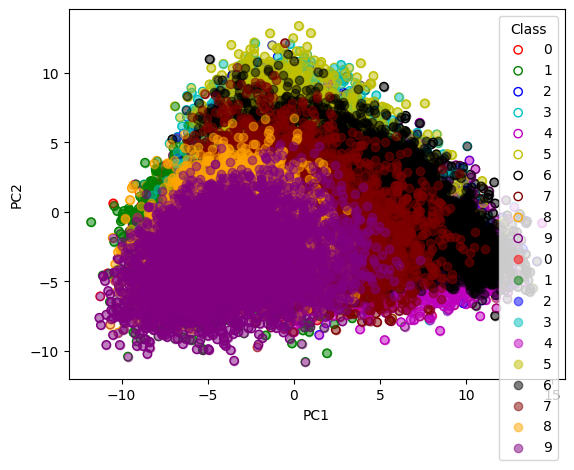

In [164]:
from sklearn.decomposition import PCA

ratio = 0.8

# split overall CNN descriptors
cnn_train_data, cnn_test_data = train_test_split(resnet_descriptors, ratio=ratio)

# split overall labels
train_labels, test_labels = label_test_split(category_of_each_image, ratio=ratio)

# The best k value for CNN descriptor
k = 40

# define the kNN classifier
knn = KNeighborsClassifier(n_neighbors=k)

# train the kNN classifier on CNN training data
knn.fit(cnn_train_data, train_labels)

# predict the labels of CNN train data
cnn_pred_labels_train = knn.predict(cnn_train_data)

# predict the labels of CNN test data
cnn_pred_labels_test = knn.predict(cnn_test_data)

# Assess accuracy of the model
cnn_accuracy = accuracy_metric(test_labels, cnn_pred_labels_test)
print(f"Accuracy of kNN classifier on CNN descriptor with k={k}: {cnn_accuracy['accuracy']:.2f}")

# Apply PCA on train CNN descriptor set
pca = PCA(n_components=2)
cnn_train_data_transform = cnn_train_data.copy()
cnn_pca = pca.fit_transform(cnn_train_data_transform)

# Plot samples using the first 2 principal components
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'maroon', 'orange', 'purple']

# Plot empty circles with ground truth labels
for i in range(10):
    plt.scatter(cnn_pca[train_labels==i, 0], cnn_pca[train_labels==i, 1], 
               marker='o', facecolors='none', edgecolors=colors[i], label=i)

        
# Plot filled circles with predicted labels
for i in range(10):
    plt.scatter(cnn_pca[cnn_pred_labels_train==i, 0], cnn_pca[cnn_pred_labels_train==i, 1], 
               c=colors[i], marker='o', label=i, alpha=0.5)


plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Class')
plt.show()

**b)** Repeat the steps mentioned before but now on the test CNN descriptor set. 

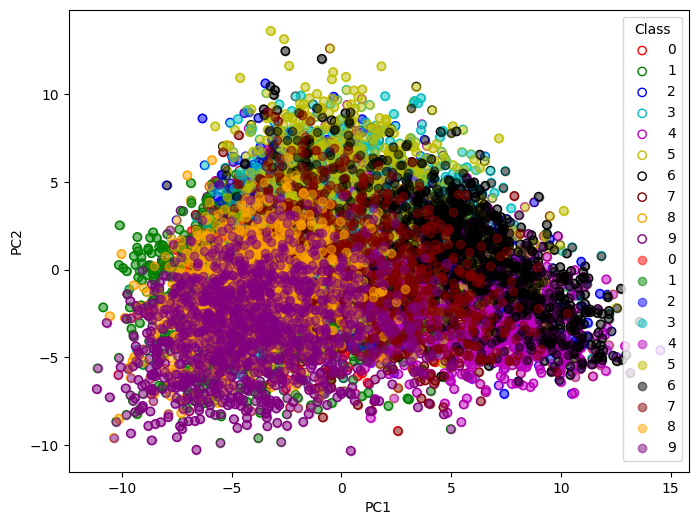

In [169]:
from sklearn.decomposition import PCA

ratio = 0.8

# split overall CNN descriptors
cnn_train_data, cnn_test_data = train_test_split(resnet_descriptors, ratio=ratio)

# split overall labels
train_labels, test_labels = label_test_split(category_of_each_image, ratio=ratio)

# The best k value for CNN descriptor
k = 40

# define the kNN classifier
knn = KNeighborsClassifier(n_neighbors=k)

# train the kNN classifier on CNN training data
knn.fit(cnn_train_data, train_labels)

# predict the labels of CNN test data
cnn_pred_labels_test = knn.predict(cnn_test_data)

# Apply PCA on test CNN descriptor set
pca = PCA(n_components=2)
cnn_test_data_transform = cnn_test_data.copy()
cnn_pca = pca.fit_transform(cnn_test_data_transform)

# Plot samples using the first 2 principal components
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'maroon', 'orange', 'purple']

# Plot empty circles with ground truth labels
for i in range(10):
    ax.scatter(cnn_pca[test_labels==i, 0], cnn_pca[test_labels==i, 1], 
               marker='o', facecolors='none', edgecolors=colors[i], linewidths=1, label=i)

        
# Plot filled circles with predicted labels
for i in range(10):
    ax.scatter(cnn_pca[cnn_pred_labels_test==i, 0], cnn_pca[cnn_pred_labels_test==i, 1], 
               c=colors[i], marker='o', label=i, alpha=0.5)


ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(title='Class')
plt.show()

#### Exercise 2.7 - kNN with k-Fold cross-validation

Assess the performance of your implemented kNN using k-Fold cross-validation. 

Run your implemented function evaluating for k (fold) = 2, 5 and 10. You can rely on the kNN that performed best in the previous exercises.
Report the average accuracy and the standard deviation.

**K-Fold cross-validation on the model based on the RGB Descriptors:**

In [171]:
# Load packages
from sklearn.model_selection import KFold
import numpy as np
from sklearn.utils import shuffle

# The kNN that performed best in the previous exercises
k_nn_best = 30

# define the k values to be tested
k_fold_list = [2, 5, 10]

# shuffle the data
rgb_descriptor, category_of_each_image = shuffle(rgb_descriptor, category_of_each_image)

# perform k-fold cross validation for each value of k
for k in k_fold_list:
    kf = KFold(n_splits=k)
    acc_list = []
    for train_idx, test_idx in kf.split(rgb_descriptor):
        # split the data into training and testing sets
        cnn_train_data = rgb_descriptor[train_idx]
        cnn_test_data = rgb_descriptor[test_idx]
        train_labels = category_of_each_image[train_idx]
        test_labels = category_of_each_image[test_idx]

        # define the kNN classifier
        knn = KNeighborsClassifier(n_neighbors=k_nn_best)

        # train the kNN classifier on CNN training data
        knn.fit(cnn_train_data, train_labels)

        # predict the labels of the testing data using the trained kNN classifier
        cnn_pred_labels_test = knn.predict(cnn_test_data)

        # calculate the accuracy of the predictions
        acc_met = accuracy_metric(test_labels, cnn_pred_labels_test)
        acc = acc_met['accuracy']
        acc_list.append(acc)

    # summarize the results of k-fold cross validation
    print(f"{k}-fold cross validation:")
    print("Accuracies per fold:", acc_list)
    avg_acc = round(np.mean(acc_list), 5)
    std_list = round(np.std(acc_list), 5)
    print("Average accuracy:", avg_acc, "+-", std_list)
    print("\n")

2-fold cross validation:
Accuracies per fold: [0.3074, 0.31268]
Average accuracy: 0.31004 +- 0.00264


5-fold cross validation:
Accuracies per fold: [0.3196, 0.3198, 0.3293, 0.324, 0.3165]
Average accuracy: 0.32184 +- 0.00443


10-fold cross validation:
Accuracies per fold: [0.32, 0.3244, 0.3182, 0.3276, 0.3322, 0.3342, 0.3302, 0.3202, 0.3232, 0.3142]
Average accuracy: 0.32444 +- 0.00618




**K-Fold cross-validation on the model based on the CNN Descriptors:**

In [130]:
# Load packages
from sklearn.model_selection import KFold
import numpy as np
from sklearn.utils import shuffle

# The kNN that performed best in the previous exercises
k_nn_best = 40

# define the k values to be tested
k_fold_list = [2, 5, 10]

# shuffle the data
resnet_descriptors, category_of_each_image = shuffle(resnet_descriptors, category_of_each_image)

# perform k-fold cross validation for each value of k
for k in k_fold_list:
    kf = KFold(n_splits=k)
    acc_list = []
    for train_idx, test_idx in kf.split(resnet_descriptors):
        # split the data into training and testing sets
        cnn_train_data = resnet_descriptors[train_idx]
        cnn_test_data = resnet_descriptors[test_idx]
        train_labels = category_of_each_image[train_idx]
        test_labels = category_of_each_image[test_idx]

        # define the kNN classifier
        knn = KNeighborsClassifier(n_neighbors=k_nn_best)

        # train the kNN classifier on CNN training data
        knn.fit(cnn_train_data, train_labels)

        # predict the labels of the testing data using the trained kNN classifier
        cnn_pred_labels_test = knn.predict(cnn_test_data)

        # calculate the accuracy of the predictions
        acc_met = accuracy_metric(test_labels, cnn_pred_labels_test)
        acc = acc_met['accuracy']
        acc_list.append(acc)

    # summarize the results of k-fold cross validation
    print(f"{k}-fold cross validation:")
    print("Accuracies per fold:", acc_list)
    avg_acc = round(np.mean(acc_list), 5)
    std_list = round(np.std(acc_list), 5)
    print("Average accuracy:", avg_acc, "+-", std_list)
    print("\n")

2-fold cross validation:
Accuracies per fold: [0.55832, 0.54768]
Average accuracy: 0.553 +- 0.00532


5-fold cross validation:
Accuracies per fold: [0.5722, 0.5752, 0.5625, 0.5741, 0.563]
Average accuracy: 0.5694 +- 0.00552


10-fold cross validation:
Accuracies per fold: [0.5798, 0.576, 0.5908, 0.5716, 0.5746, 0.5618, 0.5722, 0.5792, 0.5548, 0.5752]
Average accuracy: 0.5736 +- 0.00935




### [Optional] Exercise: further explore by: 
- implement other classifiers such as SVM or Random Forest, 
- extract other descriptors from the images such as objects or other local features,
- implement the evaluation metrics: recall, precision and f-score.

The evaluation metrics: recall, precision and f-score have been implemented. See the function `accuracy_metric(actual, predicted)` implemented in this notebook. 